## Plot hexagon modulation align EC mean orientation across 4-8 folds

In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_style("darkgrid")

data = pd.read_csv(r'/mnt/workdir/DCM/result/Specificity_to_6/nilearn_cv/sub_stats-z_roi-ec3.7_trial-all.csv')

In [135]:
# high performance filter
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
hp_info = participants_data.query(f'(game1_fmri>=0.5)and(Age>=18)')  # look out
hp_sub = hp_info['Participant_ID'].to_list()

data = data.loc[data['sub_id'].isin(hp_sub)]

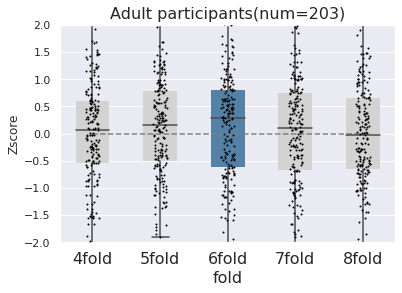

In [141]:
fig, ax = plt.subplots()
sns.boxplot(x='ifold', y="statistic", data=data, width=.5,
            palette=["lightgray", "lightgray", "steelblue", "lightgray", "lightgray"],
            boxprops={'edgecolor':'None'},showfliers=False
            )
sns.stripplot(x='ifold', y="statistic", data=data, size=2, color='.01', linewidth=0)
x = [0,1,2,3,4]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='gray')
plt.ylim(-2, 2)
plt.xticks(size=16)
plt.xlabel('fold',size=16)
plt.ylabel('Zscore')

sub_num = len(set(data['sub_id']))
plt.title("Adult participants(num={})".format(sub_num),size=16)
plt.show()

In [142]:
from scipy.stats import ttest_1samp
ifold_p = []
for i in range(4,9):
    ifold = str(i)+'fold'
    fold6_act = data[data['ifold']==ifold]['statistic'].to_list()
    _,p = ttest_1samp(fold6_act,0,alternative='greater')
    ifold_p.append(p)
    p = round(p,5)
    print('one sample t-test for {}fold: pvalue={}'.format(i,str(p).zfill(3)))

one sample t-test for 4fold: pvalue=0.63002
one sample t-test for 5fold: pvalue=0.04257
one sample t-test for 6fold: pvalue=0.03759
one sample t-test for 7fold: pvalue=0.31053
one sample t-test for 8fold: pvalue=0.5709


In [52]:
from scipy.stats import ttest_rel

act1 = data[data['ifold']=="6fold"]['statistic'].to_list()
act2 = data[data['ifold']=="7fold"]['statistic'].to_list()
_,p = ttest_rel(act1,act2)
p = round(p,6)
print('pair t-test result: pvalue={}'.format(p))

pair t-test result: pvalue=0.303347


In [ ]:

import pandas as pd
import statsmodels.api as sm

X = sub_fold_beta[['age', 'acc']]
Y = sub_fold_beta['amplitude']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

import plotly.express as px

fig = px.scatter_3d(sub_fold_beta, x='age', y='acc', z='amplitude')
fig.show()

In [221]:
from nilearn.glm import cluster_level_inference
from nilearn.image import binarize_img
from nilearn import image
z_map = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_distance_spct_ECthr3.1/Setall/6fold/group/hp_all-age/alignPhi_even_zmap.nii.gz'

z_map = image.load_img(z_map)
z_map_data = z_map.get_fdata()
print(z_map_data.mean())
z_map_data = z_map_data + 0.15
z_map = image.new_img_like(z_map,z_map_data)
print(z_map_data.mean())
mask = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
mask = binarize_img(mask)
proportion_true_discoveries_img = cluster_level_inference(
    z_map,threshold=3.1,alpha=0.05)

from nilearn import plotting
proportion_true_discoveries_img.to_filename(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_distance_spct_ECthr3.1/Setall/6fold/group/acc/alignPhi_even_acc_tmap_thr.nii.gz')

0.1485921797480985
0.2985921797480982


/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [222]:
x = proportion_true_discoveries_img.get_fdata()
len(x[x>0])

0

In [184]:
from nilearn.glm import threshold_stats_img
from nilearn.image import binarize_img
z_map = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_distance_spct_ECthr3.1/Setall/6fold/group/hp_all-age/alignPhi_even_zmap.nii.gz'
mask = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
mask = binarize_img(mask)
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni",mask_img=mask
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


The FDR=.05 threshold is 5.19


/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.553506918698067. But, you have given threshold=5.188488245753143 
  warnings.warn("The given float value must not exceed {0}. "


In [223]:
import nipype.interfaces.fsl as fsl

in_file = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_distance_spct_ECthr3.1/Setall/6fold/group/hp_all-age/alignPhi_even_zmap.nii.gz'
thresh = 2.3
p_thresh = 0.05

out_file = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_distance_spct_ECthr3.1/Setall/6fold/group/hp_all-age/alignPhi_even_zmap_thr.nii.gz'

cluster = fsl.Cluster()
cluster.inputs.in_file = in_file
cluster.inputs.threshold = thresh
cluster.inputs.pthreshold = p_thresh
cluster.inputs.out_file = out_file

TraitError: Cannot set the undefined 'out_file' attribute of a 'ClusterInputSpec' object.